# IMU

Acceleration data from the IMU.

In [1]:
from numpy import loadtxt, array, subtract, divide, multiply, median, std, var, argmax
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

g_0 = 9.80665

time = []
acc_x = []
acc_y = []
acc_z = []
acc_q = []
with open("../telemetry.csv", 'r') as f_in:
    for line, text in enumerate(f_in.readlines()):
        if line > 1:
            li = text.split(',')
            try:
                a_x = float(li[2])
                a_y = float(li[3])
                a_z = float(li[4])
                a_q = float(li[5])
            except ValueError:
                continue
            time.append(float(li[0]))
            acc_x.append(a_x)
            acc_y.append(a_y)
            acc_z.append(a_z)
            acc_q.append(a_q)

# Jump to the interesting part of the flight
cuttoff = -180000
time = time[cuttoff:]
acc_x = acc_x[cuttoff:]
acc_y = acc_y[cuttoff:]
acc_z = acc_z[cuttoff:]

# Find the moment of liftoff, set MET=0
liftoff = time[8000+argmax(acc_z[8000:9000])]
time = subtract(time, liftoff)

# Used esitmated gains and bias from http://psas.pdx.edu/DataAnalysis/
acc_x = divide(subtract(acc_x, 2400.45), 392.80)
acc_y = divide(subtract(acc_y, 2462.06), 386.90)
acc_z = divide(subtract(acc_z, 1918.72),  -77.00)
acc_q = divide(subtract(acc_q, 1907.53),  -75.40)

In [2]:
# lightly lowpass
from scipy.signal import butter, lfilter, freqz

# Filter requirements.
order = 6
fs = 2500       # sample rate, Hz
cutoff = 190   # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq

# Get the filter coefficients so we can check its frequency response.
b, a = butter(order, normal_cutoff, btype='low', analog=False)

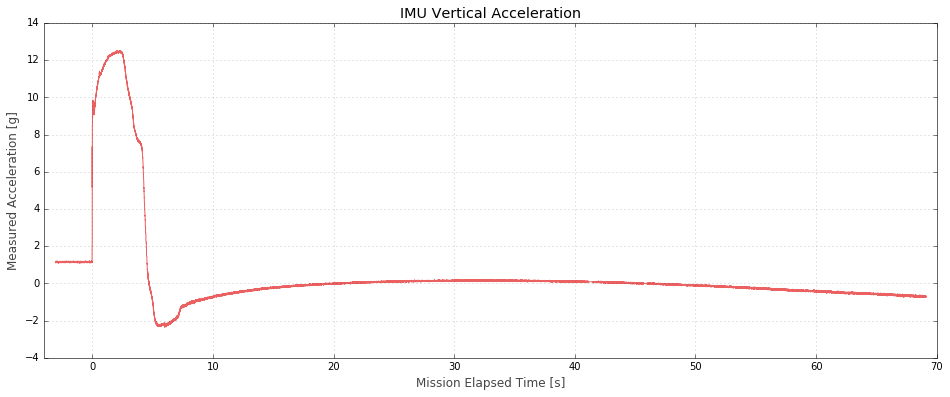

In [3]:
acc_z_filter = lfilter(b, a, acc_z)

ax = plt.figure(figsize=(16,6))
plt.title(r"IMU Vertical Acceleration")
plt.ylabel(r"Measured Acceleration [g]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot(time[1000:-1000], acc_z_filter[1000:-1000], alpha=0.7, lw=1.0)
plt.xlim([-4,70])
plt.show()

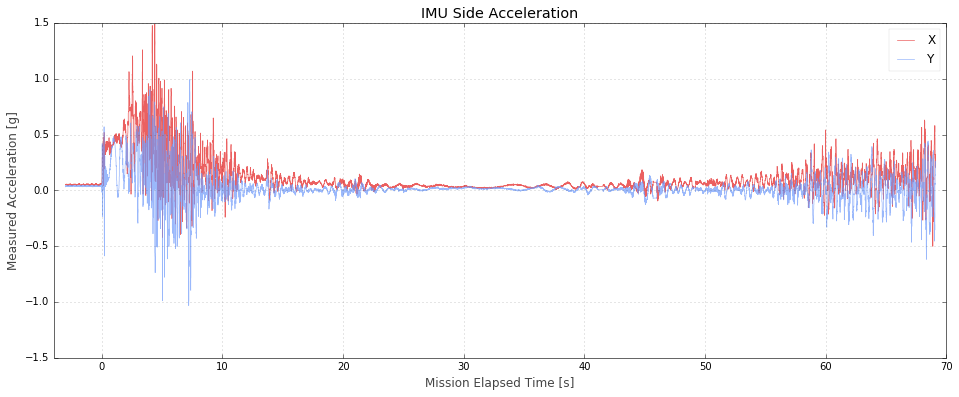

In [4]:
# Filter requirements.
order = 6
fs = 2500       # sample rate, Hz
cutoff = 40   # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq

# Get the filter coefficients so we can check its frequency response.
b, a = butter(order, normal_cutoff, btype='low', analog=False)

acc_x_filter = lfilter(b, a, acc_x)
acc_y_filter = lfilter(b, a, acc_y)

fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Side Acceleration")
plt.ylabel(r"Measured Acceleration [g]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot(time[1000:-1000], acc_x_filter[1000:-1000], alpha=0.7, lw=0.7, label="X")
plt.plot(time[1000:-1000], acc_y_filter[1000:-1000], alpha=0.7, lw=0.7, label="Y")
plt.xlim([-4,70])
ax1.legend(loc=1)
plt.show()